In [104]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
from ase import Atoms
from ase.io import read,write
import numpy as np
from deepmd.calculator import DP
from tqdm import tqdm

In [4]:
from deepmd.calculator import DP

## Test the potential

In [88]:
labels = {
  0:"Au",
  1:"H",
  2:"C",
  3:"Br",
  4:"N",
  5:"O"
}

In [95]:
typesref=np.loadtxt("NVT_C28H72Au224Br2_8000/type.raw")
listpos=np.load("NVT_C28H72Au224Br2_8000/set.000/coord.npy")
listenrgies=np.load("NVT_C28H72Au224Br2_8000/set.000/energy.npy")
listbox=np.load("NVT_C28H72Au224Br2_8000/set.000/box.npy")

In [113]:
# get the symbols
chem_symbs=[labels[i] for i in typesref]
# loope over the frames
preds=[]
for fr,pos in tqdm(enumerate(listpos)):
    # create the ASE frame
    atoms_test = Atoms(chem_symbs, 
                       positions=pos.reshape(-1,3), 
                       cell=listbox[fr].reshape(-1,3), 
                       pbc=True)
    atoms_test.calc = DP(model="graph-new-hpz4.db")
    preds.append(atoms_test.get_potential_energy())

1699it [2:56:29,  6.23s/it]


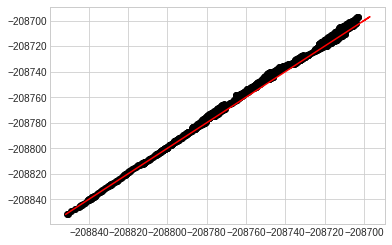

In [117]:
plt.plot(preds, listenrgies, 'o', color='black');
plt.plot(listenrgies, listenrgies, color='red');

In [119]:
from sklearn.metrics import r2_score
r2_score(preds, listenrgies)

0.9888772398772827

In [120]:
len(pos)

978

## Use the potential

In [22]:
newstr=read("C144H278Au896N12.pdb")
newstr.calc = DP(model="graph-new-hpz4.db")

In [5]:
import ase.visualize
ase.visualize.view(newstr, viewer="ase")

NameError: name 'newstr' is not defined

In [ ]:
#newstr=Atoms( positions=molbig.positions, 
#              cell=molbig.cell,
#              symbols=molbig.symbols,
#              pbc=True,
#              calculator=DP(model="graph.db"))

In [6]:
newstr

Atoms(symbols='C144H278Au896N12', pbc=True, cell=[41.272, 40.849, 48.118], atomtypes=..., bfactor=..., occupancy=..., residuenames=..., residuenumbers=..., calculator=DP(...))

In [9]:
from ase.constraints import FixAtoms

l_z=list(set(list(map(int,newstr.positions[:,2]))))
fix_z=min(l_z)+(max(l_z)-min(l_z))/2
idatoms_tobefixed = np.where(newstr.positions[:,2]<fix_z)[0]
atoms_tobefixed = FixAtoms(idatoms_tobefixed)
newstr.set_constraint(atoms_tobefixed)

In [14]:
%%timeit
print(newstr.get_potential_energy())

[-840506.06143444]
[-840506.06143444]
[-840506.06143444]
[-840506.06143444]
[-840506.06143444]
[-840506.06143444]
[-840506.06143444]
[-840506.06143444]
1.03 s ± 29.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
from ase.optimize.lbfgs import LBFGS

hareV=27.211399

opt = LBFGS(newstr)
opt.run(fmax=0.1)
forces = newstr.get_forces()
energy = newstr.get_potential_energy()
positions = newstr.get_positions()

#
print("Final energy is", energy, "eV")
print("Final energy is", energy/hareV, "hartree")

print("All done, final positions are:")
print(positions)

       Step     Time          Energy         fmax
LBFGS:    0 14:43:00  -840470.705204        9.3624
LBFGS:    1 14:43:05  -840477.925694        8.3118
LBFGS:    2 14:43:09  -840484.410031        3.5043
LBFGS:    3 14:43:13  -840487.007599        2.9266
LBFGS:    4 14:43:17  -840489.226368        2.6118
LBFGS:    5 14:43:22  -840491.400051        3.4202
LBFGS:    6 14:43:26  -840492.633983        3.7255
LBFGS:    7 14:43:30  -840494.068206        2.0331
LBFGS:    8 14:43:35  -840495.470519        1.5652
LBFGS:    9 14:43:39  -840496.297241        1.1599
LBFGS:   10 14:43:43  -840497.070945        1.4821
LBFGS:   11 14:43:47  -840497.838133        1.4801
LBFGS:   12 14:43:52  -840498.490654        1.2296
LBFGS:   13 14:43:56  -840498.984016        0.6639
LBFGS:   14 14:44:01  -840499.446900        0.7638
LBFGS:   15 14:44:05  -840499.821797        1.1168
LBFGS:   16 14:44:09  -840500.264473        0.7677
LBFGS:   17 14:44:14  -840500.697087        0.7239
LBFGS:   18 14:44:18  -840501.06

In [12]:
write("C144H278Au896N12-optimized-fix.pdb",newstr)

In [17]:
# Set the momenta corresponding to T=200K
from ase.atoms import Atoms
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase.md.langevin import Langevin
from ase import units
from ase.io.trajectory import Trajectory
import ase.io
from ase import units
hareV=27.211399

In [21]:
T = 300
MaxwellBoltzmannDistribution(newstr, T * units.kB)
# We want to run MD with constant energy using the VelocityVerlet algorithm.
dyn = VelocityVerlet(newstr, 0.5 * units.fs)  # 1 fs time step.

# NVT
dyn = Langevin(newstr, 15*units.fs, T*units.kB, 0.002)

def printenergy(a=newstr):
    """Function to print the potential, kinetic and total energy"""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))

newstr.set_constraint(atoms_tobefixed)
traj = Trajectory('moltest.traj', 'w', newstr)
dyn.attach(traj.write, interval=10)
dyn.attach(printenergy, interval=10)

# Now run the dynamics
printenergy(newstr)
dyn.run(30000)

Energy per atom: Epot = -631.948eV  Ekin = 0.020eV (T=151K)  Etot = -631.928eV
Energy per atom: Epot = -631.948eV  Ekin = 0.020eV (T=151K)  Etot = -631.928eV
Energy per atom: Epot = -631.306eV  Ekin = 22.025eV (T=170393K)  Etot = -609.281eV


KeyboardInterrupt: 

In [41]:
from xtb.ase.calculator import XTB

In [46]:
from ase.build import molecule
from xtb.ase.calculator import XTB
atoms = molecule('H2O')
atoms.calc = XTB(method="GFNFF")
atoms.get_potential_energy()

-8.912667188932252

In [47]:
newstrxtb=read("example_0_pk157415_C36H240Au896/C36H16.pdb")
newstrxtb.pbc=False
#newstrxtb.calc=XTB(method="GFN2-xTB")
newstrxtb.calc=XTB(method="GFNFF")

In [48]:
newstrxtb.get_potential_energy()

-331.25952791533

In [49]:
newstrxtb.get_forces()

array([[ 1.72187101, -1.50015425,  1.30259358],
       [-0.14412138,  2.3882399 ,  1.32592581],
       [-0.00405131, -0.40746461, -0.30760217],
       [ 0.42428782, -0.03220145,  0.01206812],
       [ 0.28310868,  0.25856275, -0.31272143],
       [-0.30887883, -0.27381145,  0.010493  ],
       [-1.83190824,  2.14918316, -0.63410253],
       [-0.33020907, -2.83717516, -0.62020549],
       [ 0.37260968, -0.42357859, -0.02752084],
       [-0.04237358,  0.19964135, -0.15805005],
       [ 0.06681635,  0.55720544,  0.03030967],
       [-0.21702531, -0.28513498, -0.1975027 ],
       [ 0.02454454, -0.14967138,  0.02598538],
       [-0.01654804,  0.05710393, -0.06829203],
       [-0.34653615, -0.34915385,  0.03263258],
       [-0.43740266, -1.09576663,  0.0453132 ],
       [ 0.54673967, -0.12920204,  0.01348441],
       [ 0.32781217,  0.42843484, -0.11685215],
       [ 1.36458373,  0.32892183,  0.15083752],
       [-0.43926   ,  0.0226114 ,  0.03225463],
       [ 0.40102722, -0.4050857 , -0.051

In [4]:
from deepmd.calculator import DP

In [52]:
newstr=read("example_0_pk157415_C36H240Au896/C36H16.pdb")
newstr.calc = DP(model="graph-new-hpz4.db")

In [53]:
newstr.get_potential_energy()

array([-5804.27991047])

In [54]:
newstrxtb.get_forces()-newstr.get_forces()

array([[ 6.89101991e-01, -1.07270988e+00, -6.63647036e-01],
       [ 2.55710298e-01,  1.29406506e+00, -7.07480051e-01],
       [ 5.20782827e-02, -4.83514080e-01,  3.85997637e-01],
       [ 3.90688908e-01, -2.06817496e-02,  6.16289601e-02],
       [ 3.05133896e-01,  3.76852141e-01,  3.99076416e-01],
       [-3.27991774e-01, -1.61922365e-01,  3.63269438e-02],
       [-1.70460272e+00,  2.66923745e-01,  2.27514268e-01],
       [ 8.93262172e-01, -1.18793222e+00,  2.59816732e-01],
       [ 3.38996548e-01, -1.34126433e-01,  8.94576507e-04],
       [-2.81824423e-02, -1.55853977e+00,  7.15269427e-01],
       [-1.31153390e-01,  3.56618041e-01, -5.15365286e-02],
       [ 1.26835569e+00,  7.79435422e-01,  7.08408049e-01],
       [ 1.17329457e+00, -6.22465033e-01, -8.21246755e-02],
       [-3.16542493e-01,  1.27013954e+00,  7.91128818e-03],
       [-1.82941197e-01, -1.54120187e-01, -3.84235985e-02],
       [-1.04826401e+00, -5.93044837e-01,  1.67476432e-02],
       [ 4.09422909e-01, -5.38378864e-04

## MIXING CALCULATORS

In [64]:
newstr_gnff=read("example_0_pk157415_C36H240Au896/C36H16.pdb")
newstr_xtb=read("example_0_pk157415_C36H240Au896/C36H16.pdb")

In [65]:
newstr_gnff.pbc=False
#newstrxtb.calc=XTB(method="GFN2-xTB")
newstr_gnff.calc=XTB(method="GFNFF")

newstr_xtb.pbc=False
newstr_xtb.calc=XTB(method="GFN2-xTB")

In [70]:
from ase.calculators.mixing import AverageCalculator,SumCalculator

In [61]:
newstr=read("example_0_pk157415_C36H240Au896/C36H16.pdb")
newstr.pbc=False

In [67]:
newstr.calc=AverageCalculator([XTB(method="GFNFF"),XTB(method="GFN2-xTB")])

In [68]:
newstr.get_potential_energy()

-1324.2741670876662

In [69]:
(newstr_xtb.get_potential_energy()+newstr_gnff.get_potential_energy())/2

-1324.2741670876649

In [71]:
newstr.calc=SumCalculator([XTB(method="GFNFF"),XTB(method="GFN2-xTB")])
newstr.get_potential_energy()

-2648.5483341753315

In [72]:
newstr_xtb.get_potential_energy()+newstr_gnff.get_potential_energy()

-2648.5483341753297